In [222]:
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade

plt.style.use('Solarize_Light2')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

# **Loading constants needed**

In [223]:
import json

with open('prams.json', 'r') as file:
    data = json.load(file)

WINDOW, PNL, SIGNALS, PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT, FIGSIZE=data['WINDOW'], data['PNL'], data['SIGNALS'], data['PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT'], data['FIGSIZE']

RRR = (PRICE_DEVIATION['ENTRY'] - PRICE_DEVIATION['TP'])/(PRICE_DEVIATION['SL'] - PRICE_DEVIATION['ENTRY'])

# **1. Loading & Cleaning Data**

In [224]:
gold_ticker = yf.Ticker("GC=F") # ticker="NQ=F"

df = gold_ticker.history(period="2y", interval='1h')

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# display(df.shape)
# display(df.head(3))

- visualizing data

<Axes: title={'center': 'Closing price'}, ylabel='price'>

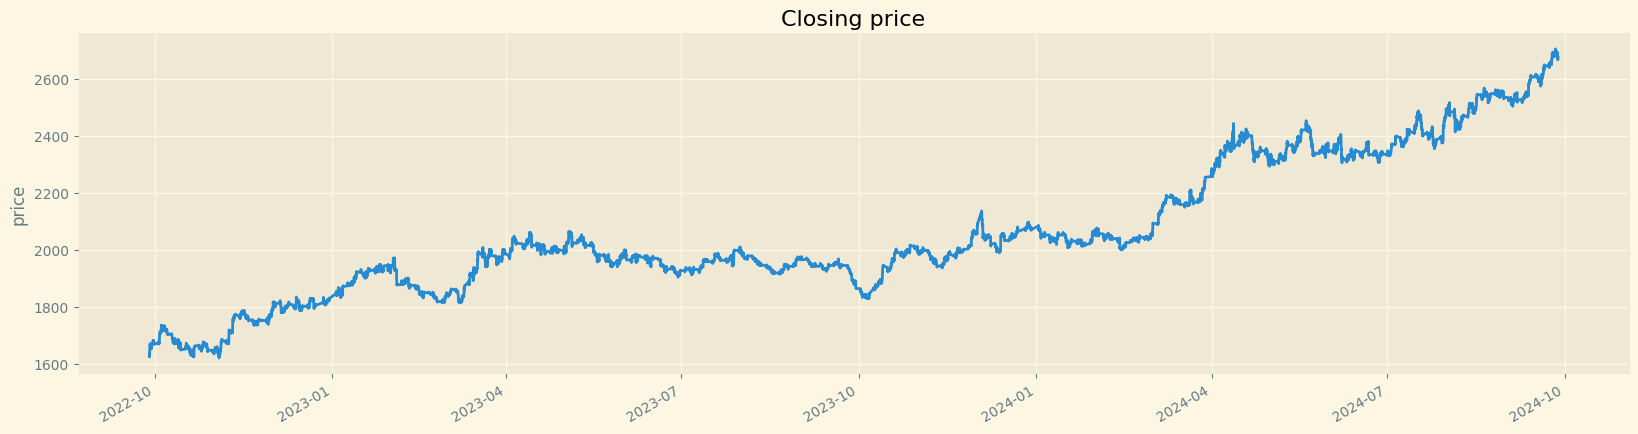

In [225]:
df['Close'].plot(xlabel='', ylabel='price', title="Closing price", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,20), sharex=True)

# # Plotting each column in a separate subplot
# df['Close'].plot(ax=axs[0], color='blue', title='High prices')
# axs[0].set_ylabel('price')

# df['Close'].plot(ax=axs[1], color='green', title='Low prices')
# axs[1].set_ylabel('price')

# df['Close'].plot(ax=axs[2], color='red', title='Opening prices')
# axs[2].set_ylabel('price')

# df['Close'].plot(ax=axs[3], color='red', title='Closing prices')
# axs[3].set_ylabel('price')
# axs[3].set_xlabel('DateTime')

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [226]:
# Low
# [TODO] try also EMA
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)

display(df.head(3))

,Open,High,Low,Close,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
Datetime,,,,,,,,,,
2022-09-28 06:00:00-04:00,1624.000000,1639.800049,1623.199951,1636.699951,1625.971418,3.173702,-0.873260,1632.485718,3.606222,2.028253
2022-09-28 07:00:00-04:00,1636.699951,1638.099976,1630.199951,1632.099976,1625.985700,3.195528,1.318796,1633.257150,4.190013,1.155802
2022-09-28 08:00:00-04:00,1632.099976,1646.699951,1631.800049,1643.400024,1626.285714,3.666272,1.504071,1635.271432,6.547429,1.745497


### Overview

<Axes: ylabel='Z-Score'>

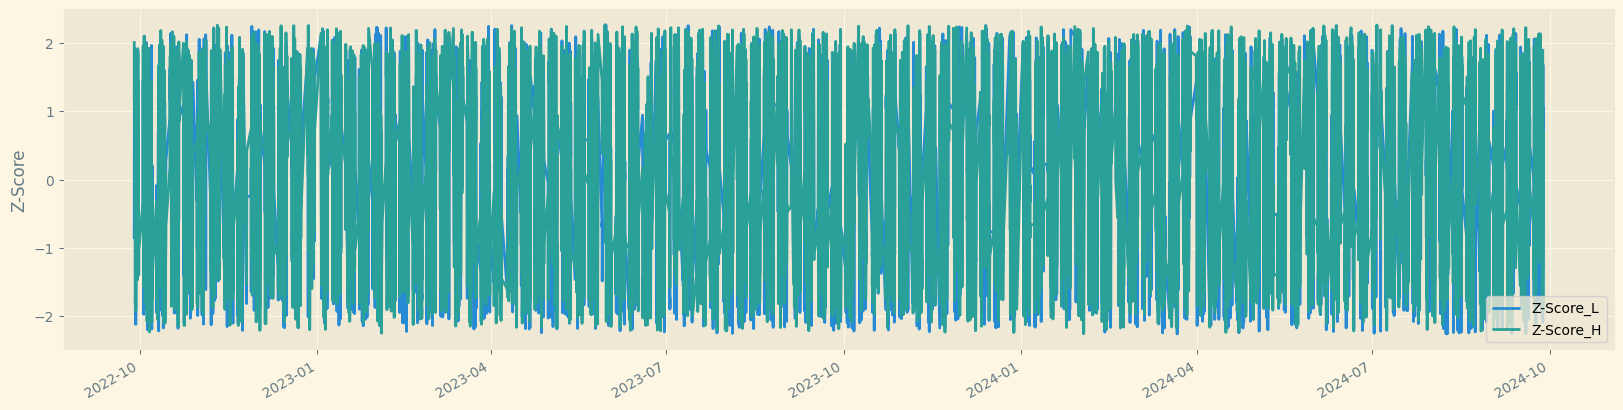

In [243]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

,Z-Score_L,Z-Score_H
max,2.267787,2.267787
min,-2.264885,-2.253863


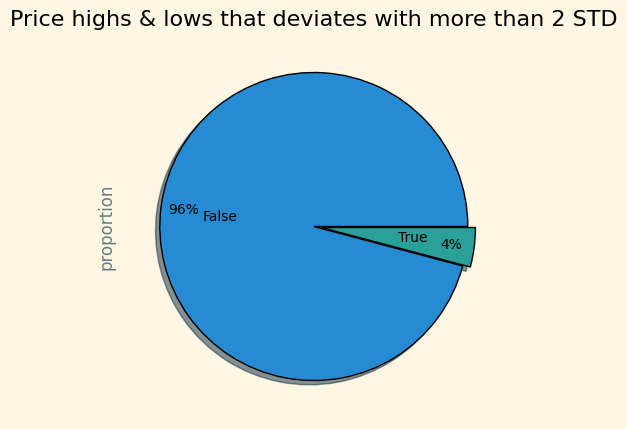

In [228]:
# same for Z-Score_H
stats = (abs(df['Z-Score_L']) > PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.plot(
    kind='pie', 
    figsize=(FIGSIZE['HEIGHT'],FIGSIZE['HEIGHT']),
    title=f"Price highs & lows that deviates with more than {PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=0.85,
    labeldistance=0.5,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    # colors=["#ECDFCC", "#3C3D37"]
)

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [229]:
price_deviate_over_xSTD_filter = df['Z-Score_H'] > PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score_L'] < -PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [230]:
df.reset_index(inplace=True)

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def exit_trade(i: int, is_win: bool):
    df.loc[i, 'Exit_Price'] = trade.tp if is_win else trade.sl
    pnl = PNL['WIN'] * RRR if is_win else PNL['LOSS']
    df.loc[i, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trade.is_buy else 'SELL']]
    return True

def is_buy_sl(i: int):
    if df.loc[i, 'Low'] <= trade.sl: return exit_trade(i, False)
    return False

def is_buy_tp(i: int, source='High'):
    if df.loc[i, source] > trade.tp: return exit_trade(i, True)
    return False

def is_sell_sl(i: int):
    if df.loc[i, 'High'] >= trade.sl: return exit_trade(i, False)
    return False

def is_sell_tp(i: int, source='Low'):
    if df.loc[i, source] < trade.tp: return exit_trade(i, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']
    L_H = POSITIONS_SHORTCUT[str(trade_signal)]
    mean_kw, std_kw = f"Mean_{L_H}", f"STD_{L_H}"
    trade.On()
    trade.entry = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['ENTRY'] * _row[std_kw])
    trade.tp = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['TP'] * _row[std_kw])
    trade.sl = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['SL'] * _row[std_kw])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if trade_signal == SIGNALS['BUY']:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    elif trade_signal == SIGNALS['SELL']:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(i): trade.Off()
            elif is_buy_tp(i, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(i): trade.Off()
            elif is_sell_tp(i, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, i)

# **4. Backtesting & Overview**

In [231]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0

if not PnL.empty:
    win_rate = PnL.iloc[0]

expectency = (RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        RRR,
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)
strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return
Metrics,499.0,206.0,56.51,1.5,0.412826,206.0


- **PnL**

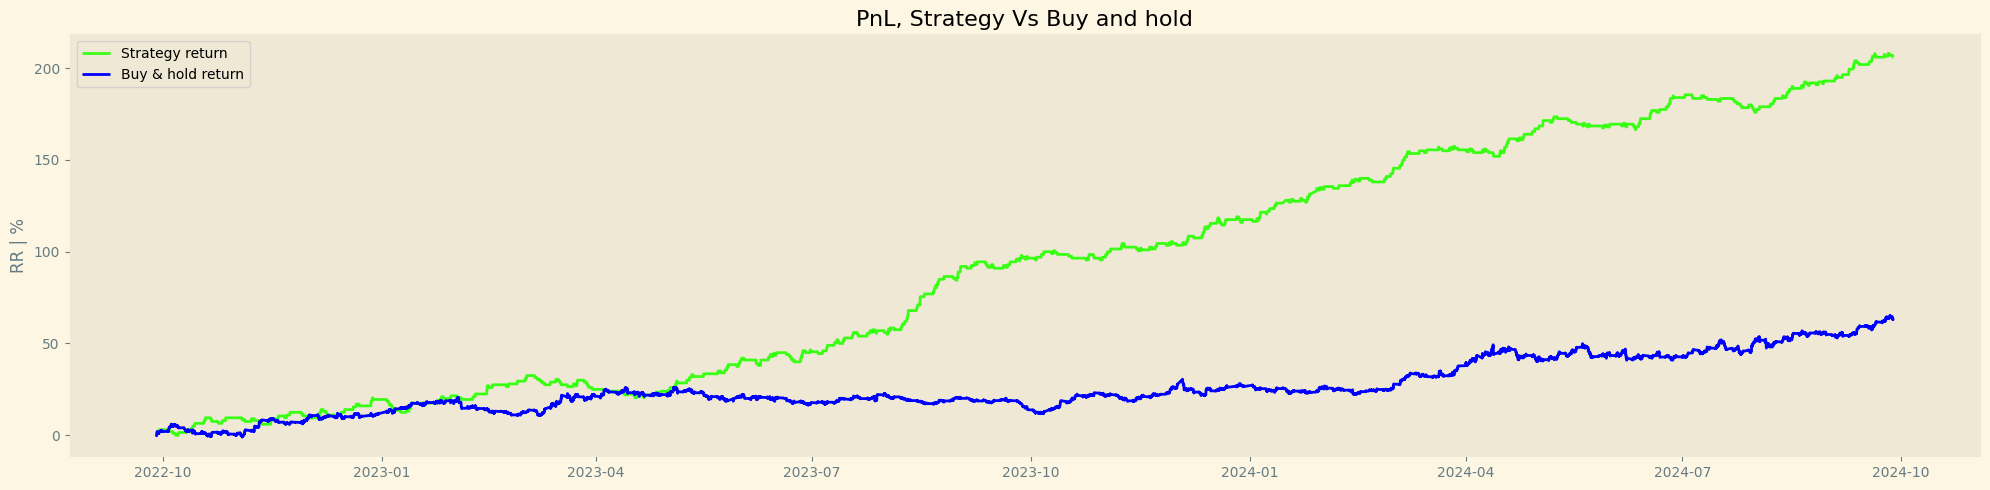

In [232]:
df.set_index('Datetime', inplace=True)

starting_inv_price = df['Close'].iloc[0]

# Create a figure and axis
plt.figure(figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))

# Plot the Strategy returns
plt.plot(df['Cumulative_PnL'], label='Strategy', color='#39FF14')

# Plot the Buy & hold returns
plt.plot((100 * (df['Close'] - starting_inv_price)/starting_inv_price), label='Buy & hold', color='blue')

# Customize the chart
plt.title('PnL, Strategy Vs Buy and hold')
plt.xlabel('')
plt.ylabel('RR | %')
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

- **PnL-Drawdown** (not from Equity)

<Axes: title={'center': 'PnL-Drawdown'}, ylabel='RR | %'>

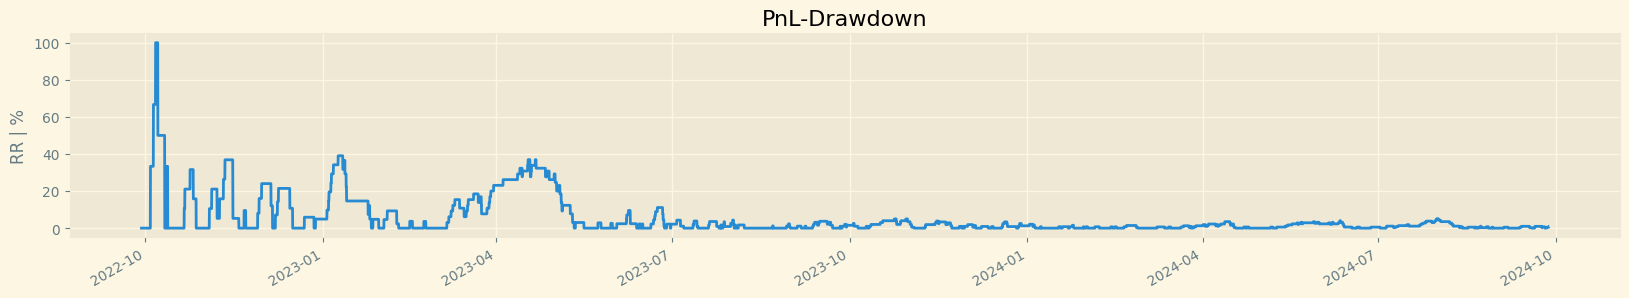

In [233]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
    title="PnL-Drawdown",
    ylabel="RR | %",
    xlabel=''
)

In [234]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 100.0 %


# **5. A study on Drawdown**

In [235]:
# [TODO] periods where drawdown (over 50%) happened

# **6. Overview on positions**

<Axes: >

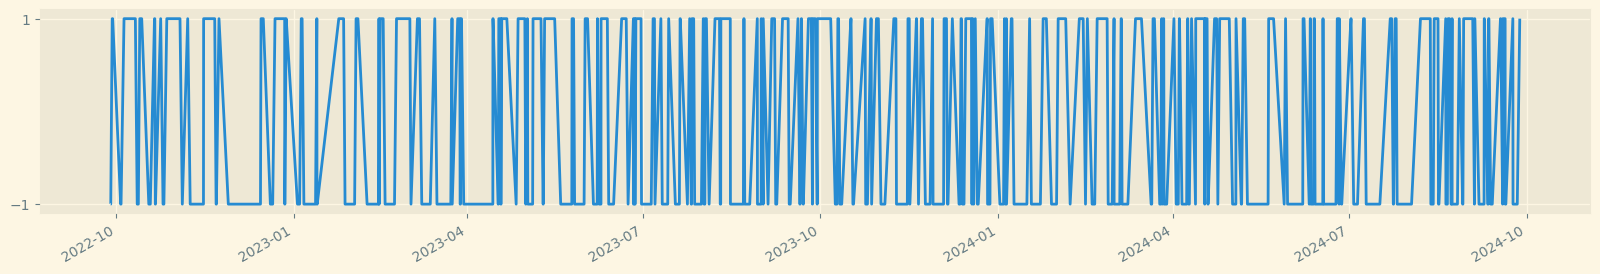

In [236]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(20, 3), xlabel='', yticks=[-1, 1])

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

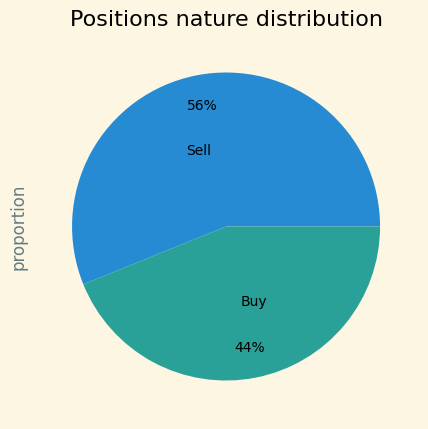

In [237]:
positions_nature_distribution_df = df.loc[filtrty, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Long & Short from losing positions'}, ylabel='proportion'>

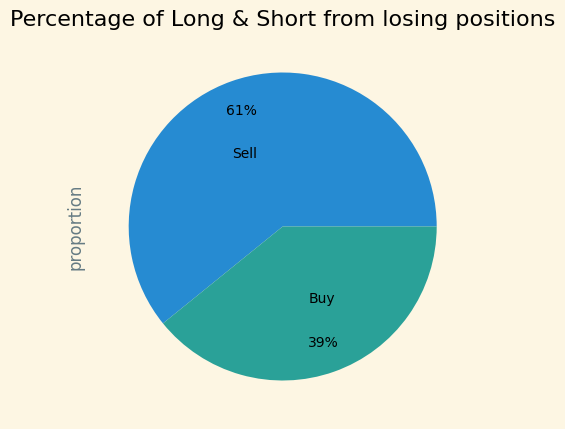

In [244]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Long & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

In [239]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)